# Basic imports for Mask R-CNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from skimage import transform
import skimage.io


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATA_DIR = os.path.join(ROOT_DIR, "../data")

MASK_DIR  = os.path.join(DATA_DIR,'segmentation')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")

#Make GPUs visible
!export HIP_VISIBLE_DEVICES=1,2,3

#Set which GPU devices' memory should be accessible to running GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

#Make only 1 GPU visible
# !export HIP_VISIBLE_DEVICES=2,3

#Set which GPU devices' memory should be accessible to running GPUs
# os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Using TensorFlow backend.


# Pull in annotations from database (from Simplot)

In [2]:
import pyodbc
import os
import pandas as pd

DATA_DIR = os.path.join(ROOT_DIR, "../data")

COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")

ANNOTATION_COLS = ['XMax','XMin','YMin','YMax','LabelDescription']

passwd = os.environ['dgs_sandbox_pwd']

conn = pyodbc.connect('DSN=BIdevDatabase;'
                      'Database=Sandbox;'
                      'UID=DGSuser;'
                      'PWD=' + passwd)


class_descriptions = pd.read_csv(os.path.join(DATA_DIR, "seg_class_descriptions.csv"))

#add 1 since Background class is automatically added at index 0
class_descriptions['LabelID'] = class_descriptions.index + 1

#This now holds the annotation information.
# bboxes = pd.read_sql("SELECT ImageID, XMax, XMin, YMin, YMax, LabelName FROM [Sandbox].[kaggle].[Combined_Set_Detection_BBox]", conn)

seg_anns = pd.read_sql("SELECT MaskPath, ImageID, LabelName, BoxID, BoxXMin, BoxXMax, BoxYMin, BoxYMax, PredictedIoU, Clicks, SourceDataset from [kaggle].[Combined_Annotations_Object_Segmentation]", conn)

annotations = pd.merge(seg_anns,class_descriptions, on='LabelName',how='inner')

# This now holds the list of images
image_paths = pd.read_sql("SELECT ImageID, RelativePath, Height, Width, Mode from [kaggle].[Image_Path]", conn)

# Inner join on the two dataframes, so we now have images combined with associated annotations
annotated_image_paths = pd.merge(image_paths,annotations, on='ImageID',how='inner')

display(annotated_image_paths.head())

,ImageID,RelativePath,Height,Width,Mode,MaskPath,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks,SourceDataset,LabelDescription,LabelID
0,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,2fef4dd2f83feb18_m03q5c7_137bd6f7.png,/m/03q5c7,137bd6f7,0.000000,0.332031,0.866667,0.998958,0.90143,0.24217 0.94703 0;0.00391 0.92179 1;0.20982 0....,train,Saucer,227
1,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,2fef4dd2f83feb18_m03q5c7_a71b69a2.png,/m/03q5c7,a71b69a2,0.602344,0.943750,0.832292,0.998958,0.70389,0.94606 0.97422 0;0.73046 0.98004 0;0.65190 0....,train,Saucer,227
2,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,2fef4dd2f83feb18_m01fh4r_fc8c0f7f.png,/m/01fh4r,fc8c0f7f,0.521875,0.730469,0.544792,0.807292,0.89666,0.58617 0.57602 1;0.52698 0.64530 1;0.72174 0....,train,Teapot,66
3,307002c02f4e6862,train/307002c02f4e6862.jpg,683,1024,RGB,307002c02f4e6862_m01xyhv_b3d4aba4.png,/m/01xyhv,b3d4aba4,0.528472,0.688194,0.114583,0.929167,0.84987,0.65489 0.31411 0;0.59700 0.46792 0;0.62842 0....,train,Suit,282
4,307002c02f4e6862,train/307002c02f4e6862.jpg,683,1024,RGB,307002c02f4e6862_m01xyhv_28039dbb.png,/m/01xyhv,28039dbb,0.609028,0.833333,0.235417,0.998958,0.69473,0.69644 0.39342 0;0.65600 0.26550 0;0.67974 0....,train,Suit,282


# Configurations

In [3]:
class KaggleConfig(Config):
    
    NAME = "kaggle"

    #TODO experiment with this
    GPU_COUNT = 3
    IMAGES_PER_GPU = 5  # TODO how many can we use, authors had 2 for 12 GB, we have 32 GB so ...

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(class_descriptions)  # + 1 for background

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.85
    
config = KaggleConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     15
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      3
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                313
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

# Subclass utils.Dataset for entire experiment

In [4]:
class SegKaggleImageDataset(utils.Dataset):
         
    def load_kaggle_images(self, dataset_dir, grouped_by_images):
        """Load a subset of the image dataset.
        dataset_dir: The root directory of the image dataset.
        classes: Dataframe : If provided, only loads images that have the given classes.
        """

        # Add classes, BG is automatically added at index 0
        for _,row in class_descriptions.iterrows():
            self.add_class("openImages", row['LabelID'], row['LabelDescription'])
        
        # Add images
        for i,df in grouped_by_images:    
            row = df.iloc[0]
            
            self.add_image(
                "openImages", image_id=i,
                path=os.path.join(dataset_dir, row['RelativePath']),
                width=row["Width"],
                height=row["Height"],
                annotations=df)
    

    def load_mask(self, image_id):
        """Generate instance masks for an image.  Based on the nucleus sample
        
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        # Create rectangular bounding box since we are doing object detection, not segmentation
        # desired dimension is [height, width, instance_count]
        img = self.image_info[image_id]
        
        masks = []
        
        for i,(_,p) in enumerate(img["annotations"].iterrows()):   
            mpath = os.path.join(MASK_DIR, p['MaskPath'])
            raw_mask = skimage.io.imread(mpath)
            masks.append(transform.resize(raw_mask,(img['height'],img['width'])))
        
#         for i,(_,p) in enumerate(img["annotations"].iterrows()):   
#             mpath = os.path.join(MASK_DIR, p['MaskPath'])
#             masks.append(skimage.io.imread(mpath))

        mask = np.stack(masks, axis=-1)
        
        return mask,np.array(img['annotations']['LabelID'].values, dtype=np.int32)

    def image_reference(self, image_id):
        return self.image_info[image_id]['path']
    

# Load dataset and display samples

## Instantiate the Full Kaggle Image Dataset classes

In [5]:
def load_dataset(source_str):
    seg_paths = annotated_image_paths[annotated_image_paths['SourceDataset'] == source_str]

    seg_grouped = seg_paths.groupby('ImageID')
    
    dataset_seg = SegKaggleImageDataset()
    dataset_seg.load_kaggle_images(DATA_DIR, seg_grouped)
    dataset_seg.prepare()
    
    return dataset_seg


dataset_train = load_dataset('train')
dataset_val = load_dataset('validation')

### Sanity check that masks look alright

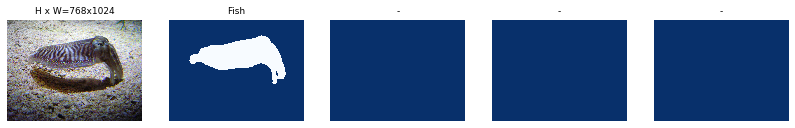

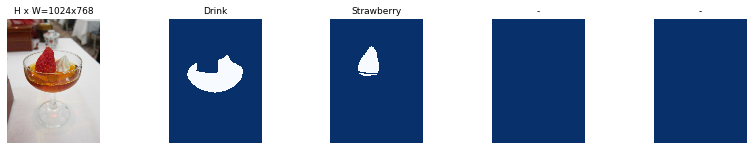

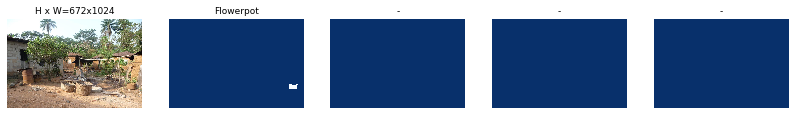

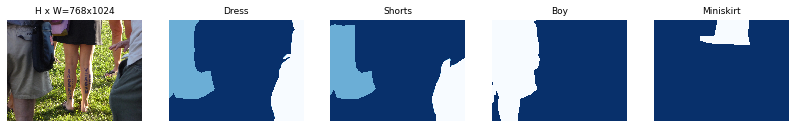

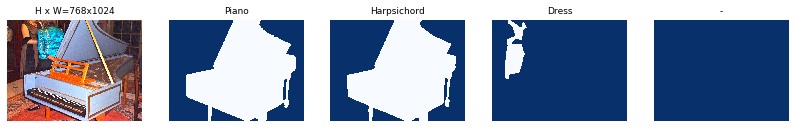

In [6]:
# Load and display random samples ... sanity check for data load
def display_mask_samples(dataset):
    image_ids = np.random.choice(dataset.image_ids, 5)

    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
        
display_mask_samples(dataset_val)

# Training

## Create model and load prior weights

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Train

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. Passing layers="all" trains all layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=500, 
            layers='heads')

# Detection

In [ ]:
class InferenceConfig(Config):
    NAME = 'KaggleInf'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + len(class_descriptions)
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, "logs/kaggle20190911T1433/mask_rcnn_kaggle_0200.h5")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

## Sanity Check on validation set

In [ ]:
#test on a few random images
image_ids = np.random.choice(dataset_val.image_ids, 5)

images = []

for iid in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, iid, use_mini_mask=False)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))
    
    images.append(original_image)


In [ ]:
results = [model.detect([img], verbose=0) for img in images]

for i in range(len(results)):
    r = results[i][0]
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'])

## On Test set

In [ ]:
from PIL import ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

#TODO image_info should be 2d array, with each row of form id, width, height
def append_to_file(filename, results, image_info):
    
    all_preds = []
    
    for j, r in enumerate(results):
        preds = []
        ids = r['class_ids']
        boxes = r['rois']
        scores = r['scores']

        img_id = image_info[j][0]
        height = image_info[j][2]
        width = image_info[j][1]
        
        preds = ''

        for i in range(len(r['class_ids'])):
            xmin = max(boxes[i][1] / width , 0.0)
            ymin = max(boxes[i][0] / height, 0.0)
            xmax = min(boxes[i][3] / width, 1.0)
            ymax = min(boxes[i][2] / height, 1.0)
            
            preds += " " + " ".join(map(str,[omni_class_set.iloc[ids[i]]['LabelName'], scores[i], xmin,ymin,xmax,ymax]))

        all_preds.append(img_id + "," + preds)
        
    with open(filename, 'a') as f: 
        f.write('\n'.join(all_preds))
        f.write('\n')
    
    

testdir = os.path.join(DATA_DIR, "test")
batch_size = 500


def write_sub_file(filename, start_index=0):
    results = []
    image_info = []


    for subdir, dirs, files in os.walk(testdir):
        for cnt,file in enumerate(files):

            #use this if the process broke down at some point and you need to restart midway through ... total hack
            if cnt < start_index:
                continue

            img = skimage.io.imread(os.path.join(subdir, file))

            #filename, width, height
            image_info.append([file[:-4],img.shape[1],img.shape[0]])

            results += model.detect([image], verbose=0)

            if (cnt%batch_size == (batch_size-1)):
                print("writing to file ... ")
                append_to_file(filename, results,image_info)
                results = []
                image_info = []
                print(cnt," completed") #100,000 images in the test set
                
    print("writing final records to file ... ")
    append_to_file(filename, results,image_info)
    print(cnt," completed")
    
    return cnt

### Sanity Check

In [ ]:
dataset = dataset_val

image_ids = np.random.choice(dataset.image_ids, 5)

ver_images = []

for iid in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config, iid, use_mini_mask=False)
    
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))
    
    ver_images.append(original_image)

results = [model.detect([img], verbose=0) for img in ver_images]

for i in range(len(results)):
    r = results[i][0]
    visualize.display_instances(ver_images[i], r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

# Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 500)

#each input is a tuple of form : image, image_meta, gt_class_id, gt_bbox, gt_mask
inputs = [modellib.load_image_gt(dataset_val, inference_config, iid, use_mini_mask=False) for iid in image_ids]

APs = []

n = inference_config.BATCH_SIZE

for i in range(0,len(image_ids),n): 

    curr_inputs = inputs[i:i+n]
    
    results = model.detect([inp[0] for inp in curr_inputs], verbose=0)
    
    for j in range(len(results)):
        r = results[j]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(curr_inputs[j][3], curr_inputs[j][2], curr_inputs[j][4],
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    
print("mAP: ", np.mean(APs))

# Generate submission file

## Encode instance segmentation map (from kaggle competition website)

In [ ]:
# container does not include this library by default, will need to run this once
# !pip install pycocotools

In [ ]:
import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray):

     # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
           "encode_binary_mask expects a binary mask, received dtype == %s" %
           mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
           "encode_binary_mask expects a 2d mask, received shape == %s" %
           mask.shape)

     # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

## Define batch-write functions

In [ ]:
from PIL import ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

#TODO image_info should be 2d array, with each row of form id, width, height
def append_to_file(filename, results, image_info):
    
    all_preds = []
    
    for j, r in enumerate(results):
        preds = []
        ids = r['class_ids']
        masks = r['masks']
        scores = r['scores']

        img_id = image_info[j][0]
        height = image_info[j][2]
        width = image_info[j][1]
        
        preds =''

        for i in range(len(r['class_ids'])):
            # masks are stored as a 3d array, <height,width,# examples>, so we need to index into it in a special way
            enc_mask = encode_binary_mask(masks[:,:,i])
            #subtract 1 to compensate for the background
            class_name = class_descriptions.iloc[ids[i]-1]['LabelName']
            preds += " " + " ".join(map(str,[class_name, scores[i], enc_mask.decode()]))

        img_lvl_fields = ','.join(map(str,[img_id,width,height]))
        all_preds.append(img_lvl_fields + "," + preds)
        
    with open(filename, 'a') as f: 
        f.write('\n'.join(all_preds))
        f.write('\n')
        

testdir = os.path.join(DATA_DIR, "test")

def write_sub_file(filename, batch_size=500, start_index=0):
    results = []
    image_info = []


    for subdir, dirs, files in os.walk(testdir):
        for cnt,file in enumerate(files):

            #use this if the process broke down at some point and you need to restart midway through ... total hack
            if cnt < start_index:
                continue

            img = skimage.io.imread(os.path.join(subdir, file))

            #filename, width, height
            image_info.append([file[:-4],img.shape[1],img.shape[0]])

            results += model.detect([img], verbose=0)

            if (cnt%batch_size == (batch_size-1)):
                print("writing to file ... ")
                append_to_file(filename, results,image_info)
                results = []
                image_info = []
                print(cnt," completed") #100,000 images in the test set
                
    print("writing final records to file ... ")
    append_to_file(filename, results,image_info)
    print(cnt," completed")
    
    return cnt

## Execute batch writing

In [ ]:
filename = os.path.join(ROOT_DIR, 'seg_submission_9_16.csv')

### Generate the entire file

In [ ]:
with open(filename, 'w+') as f:
    f.write('ImageId,ImageWidth,ImageHeight,PredictionString\n')
    
write_sub_file(filename, start_index=0)

### Resume writing the file

In [ ]:
# use X + 1 , where X is from the 'X completed' statement above
write_sub_file(filename, start_index=6500)

### Manipulate submission file

In [ ]:
# df = pd.read_csv(submission_file)

# nu = df['ImageId'].nunique()  # Should be 99999

# if len(df) > nu
#     df.drop_duplicates('ImageId', inplace = True)

# df.to_csv('submission_9_11_0.csv',index=False)

# Debugging cells

In [ ]:
## Look up the details for an image and its associated mask to ensure that sizes are correctly mapped

# mpath = dataset.image_reference(548819)
# mpath = dataset.image_reference(263657)
# skimage.io.imread(mpath).shape

def get_details(img_id):
    f_path = dataset.image_reference(img_id)
    f_shape = skimage.io.imread(f_path).shape
    f_ratio = f_shape[0]/f_shape[1]
    q = f_path.split('/')[-2:]
    rel_m_path = annotated_image_paths[annotated_image_paths['RelativePath'] == '/'.join(q)]['MaskPath'].iloc[0]
    m_path = os.path.join(DATA_DIR,'segmentation',rel_m_path)
    m_shape = skimage.io.imread(m_path).shape
    m_ratio = m_shape[0]/m_shape[1]
    
    return [img_id, f_path,f_shape,f_ratio,m_path,m_shape,m_ratio]

x = [get_details(iid) for iid in image_ids]

pd.DataFrame(x,columns=['iid','f_path','f_shape','f_ratio','m_path','m_shape','m_ratio'])